In [1]:
import os

# home_dir = '/content/gdrive/My Drive/AChina' 
# home_dir = '/hy-tmp'
# os.chdir(home_dir)
# pwd

!pip install tqdm 
!pip install fire

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import os
import warnings
import sys

import fire

# warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")

!pip install scipy
!pip install torch 
!pip install pytorch_lightning==1.9.0 pytorch_forecasting

import copy
from pathlib import Path
import warnings

import time

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE, SMAPE, PoissonLoss, QuantileLoss, RMSE, MAE
from matplotlib import pyplot as plt
from pytorch_lightning.utilities.model_summary import summarize
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from matplotlib import pyplot as plt

from multiprocessing import Pool, freeze_support

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
home_dir = '/hy-tmp'        
os.chdir(home_dir)

!pwd

# !ls

pl.seed_everything(1234, workers=True)

# from google.colab import drive
# drive.mount('/content/gdrive/')

# !ls

# home_dir = '/content/gdrive/My Drive/AChina'        
# os.chdir(home_dir)
# !pwd

/hy-tmp


Global seed set to 1234


1234

In [3]:
# data = np.load('A0mod_A0cr[rice]-yr[2005_2010_2017]-en[A0_RMSE_cyclic]-bs[128]-lr[0.01]_predict.npz')
# data = np.load('A0mod_A0cr[rice]-yr[2005_2010_2017]-en[A0_RMSE_cyclic]-bs[128]-lr[0.01]_test.npz')
# filename = f'EXP_[A0AF_RMSE]-Cr[rice]-KF[2005_2010_2017]-BS[128]]'
# filename = f'EXP_[A0AF_RMSE]-Cr[rice]-KF[2005_2010_2017]-BS[128]]'
filename = f'EXP_[A0AM_TRAIN]-Cr[rice]-KF[2005_2010_2017]-BS[128]]'

data = np.load(f'{filename}_predict.npz')
# data = np.load('A0Bmod_A0Bcr[rice]-yr[2005_2010_2017]-en[A0B]-bs[128]-lr[0.01]_test_.npz')
checkpoint_file = f'{filename}'

for ks in data.keys():
    print(ks)


actuals
predictions
prediction
encoder_target
decoder_target


Global seed set to 123456


A0AM_vis rice
predicted_years: ['2005', '2010', '2017'] max_epochs: 100 batch_size: 16 learning_rate 0.0325 loss_func_metric: RMSE seed: 123456 lr_milestones_list: [20, 50, 600, 800]
loading data/ALIM128F64DATASET_rice.csv Mon Apr 10 22:55:30 2023
data/ALIM128F64DATASET_rice.csv loaded Mon Apr 10 22:55:39 2023
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'numpy.int64'>


/hy-tmp/yieldos/A0AM.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_infer[f'{self.scrop}_sownarea'] = 0.0    #np.nan
/hy-tmp/yieldos/A0AM.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_infer[f'{self.scrop}_yieldval'] = 0.0    #np.nan
/hy-tmp/yieldos/A0AM.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Years to train: ['2003', '2004', '2006', '2007', '2008', '2009', '2011', '2012', '2013', '2014', '2015', '2016', '2018']
Years to valid: ['2005', '2010', '2017']
--------check 2008----------------------
Years to train: ['2003' '2004' '2006' '2007' '2009' '2011' '2012' '2013' '2014' '2015'
 '2016' '2018']
Years to valid: ['2005', '2010', '2017']
Years to valid: ['2005' '2010' '2017']
------------------------------


/hy-tmp/yieldos/A0AM.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[f'{self.scrop}_yield'].loc[(self.data['county'] == county) & (self.data['year'] == year) & \
/hy-tmp/yieldos/A0AM.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['gstage'].loc[(self.data['county'] == county) & (self.data['year'] == year) & \
/hy-tmp/yieldos/A0AM.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_val[f'{self

DATA_VAL: ['0' '1' '2'] (2754, 2809)
DATA_VAL: ['0' '1' '2'] (918, 2809)
DATA_VAL: ['0' '1' '2'] (34, 2809)
Augmentation for years list: [2003, 2004, 2006, 2007, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2018] by NSAMPLES=3 and YEARS_MAX_LENGTH=3


100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


type(self.data_train[time_idx]) <class 'pandas.core.series.Series'>
time_idx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
sample ['0' '1' '2']
county ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '11' '12' '13' '14' '15' '16'
 '17' '19' '21' '22' '23' '24' '25' '26' '27' '29' '30']
df[year].unique() ['2003' '2006' '2005']
df[time_idx].to_numpy() [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70

/hy-tmp/yieldos/A0AM.py:414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfali['time_idx'] = dflast['time_idx'].values


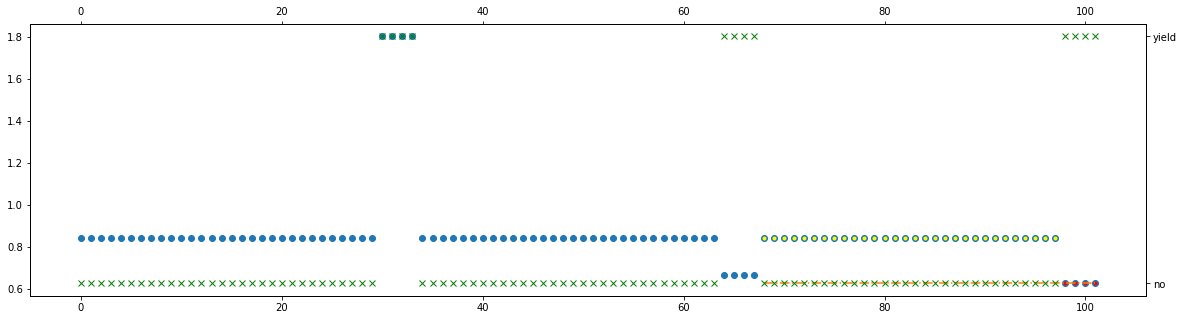

Dataframe size: 176.33 Mb
DataGenerator done...
Set basic filenames self.name_for_files: EXP_[A0AM_vis]-Cr[rice]-KF[2005_2010_2017]-BS[16]]
avg_med: ['avg_rice_yield', 'actuals']
training mx_epochs, TimeSeriesDataSet: 100 Mon Apr 10 22:56:05 2023
D1: known-unknown go --------------------------
D2: --------------------------
Mon Apr 10 22:56:51 2023
training & validation TimeSeriesDataSet loaded Mon Apr 10 22:57:49 2023
self.train_dataloader: 340
self.val_dataloader: 3
self.test_dataloader: 3
Mon Apr 10 22:57:49 2023


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Baseline: tensor(0.0451)
Baseline: Mon Apr 10 22:57:54 2023
test
weights loading from checkpoint: EXP_[A0AM_TRAIN]-Cr[rice]-KF[2005_2010_2017]-BS[128]] Mon Apr 10 22:57:57 2023
weights loaded Mon Apr 10 23:01:17 2023
MAPE: {tensor(6.0674)}
SMAPE: {tensor(5.8824)}


AttributeError: 'ModelBase' object has no attribute 'filename'

<Figure size 432x288 with 0 Axes>

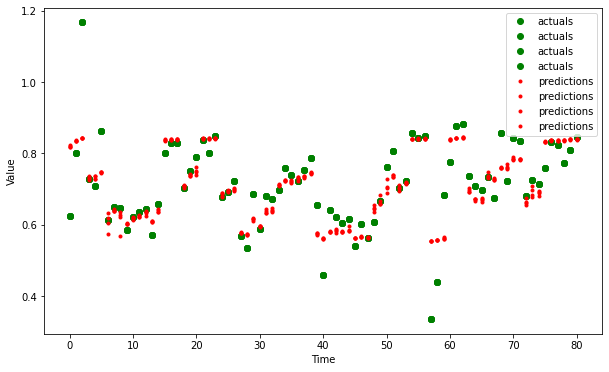

In [4]:
from A0AM import ModelBase

def train_TFT(exp_name, 
              crop_name='rice', 
              predicted_years="2005 2010 2017",
              batch_size=16,
              learning_rate=0.0325,
              loss_func_metric='RMSE', 
              max_epochs=100,
              checkpoit_file=checkpoint_file):

    # print('predicted year:', predicted_years, type(predicted_years))

    # torch.set_float32_matmul_precision('medium')

    log_file = os.path.join('/hy-tmp', f'Log-cr[{crop_name}]-yr[{predicted_years}]-en[{exp_name}]-bs[{batch_size}].log')

#         if os.path.exists(log_file):
#             print(f'log file {log_file} exist')
#             sys.exit(0)

#         sys.stdout = Logger(log_file)

    model = ModelBase(exp_name=exp_name, 
                      predicted_years=predicted_years,
                      max_epochs=max_epochs, 
                      batch_size=batch_size, 
                      learning_rate=learning_rate,
                      loss_func_metric=loss_func_metric)

    # model.init_lr_finder()
    # model.custom_finder()
    # model.train()
    # model.predict()
    model.test(checkpoit_file=checkpoint_file)
    # model.inference()
    # model.plot_predict()
    print('The end...')
    sys.exit(0)
    
train_TFT(exp_name='A0AM_vis', checkpoit_file=checkpoint_file)

In [ ]:
fn
print(data['prediction'].shape, data['encoder_target'].shape, data['decoder_target'].shape)
print( np.asarray(data['prediction'][0,0,0]) )
print( np.asarray(data['prediction'][0]) )

In [ ]:
MOD_BINS = 128
FAM_BINS = 64
datasetfile = f'data/ALIM{MOD_BINS}F{FAM_BINS}DATASET_rice.csv'
alidata = pd.read_csv(os.path.join(home_dir,datasetfile))

alidata.head()

In [ ]:
samples = [X for X in range(data['prediction'].shape[0])]

X = [X for X in range(0,5)]

# X = [X for X in range(data['encoder_target'][0:10])]

print(X)

X.append(len(X))

print(X)

files = [1,]

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
for sample in samples:
    # data = np.load(ifile)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
    
    Y = np.array([])
    Y_= np.array([])
    
    Y = np.concatenate( (Y, np.asarray(data['encoder_target'][sample][...])) )
    Y_= np.concatenate( (Y_, np.asarray(data['encoder_target'][sample][...])) )
    
    # print(Y.shape)
    # fn

    # Y = np.asarray(data['decoder_target'][sample][...]) 
    # Y_ = np.asarray(data['prediction'][sample,...,0]) 
    
    Y = np.concatenate( (Y, np.asarray(data['decoder_target'][sample][...])) ) 
    Y_ = np.concatenate((Y_, np.asarray(data['prediction'][sample,...,0])) ) 
    
    # print(county, Y)
    # print(Y_)
    X = [X for X in range(len(Y))]
    ax.plot(np.asarray(X), np.asarray(Y), 'o', color='green')
    ax.plot(np.asarray(X), np.asarray(Y_), '.', color='red')
    ax.set(title=sample)
plt.ylim([0, 1.3])
plt.show()

# for ifile in files:
#     # data = np.load(ifile)
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
#     for county in counties:
#         Y = np.asarray(data['decoder_target'][county][0]) 
#         Y_ = np.asarray(data['prediction'][county,0,0]) 
#         # print(county, Y)
#         # print(Y_)
#         ax.plot(np.asarray(county), np.asarray(Y), 'o', color='green')
#         ax.plot(np.asarray(county), np.asarray(Y_), '.', color='red')
#         ax.set(title=ifile)
#     plt.ylim([0, 1.3])
#     plt.show()

In [ ]:
fn